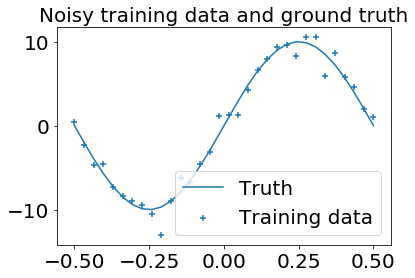

In [25]:
import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline

def f(x, sigma):
    epsilon = np.random.randn(*x.shape) * sigma
    return 10 * np.sin(2 * np.pi * (x)) + epsilon

train_size = 32
noise = 1.0

X = np.linspace(-0.5, 0.5, train_size).reshape(-1, 1)
y = f(X, sigma=noise)
y_true = f(X, sigma=0.0)

plt.scatter(X, y, marker='+', label='Training data')
plt.plot(X, y_true, label='Truth')
plt.title('Noisy training data and ground truth')
plt.legend();

In [2]:
from keras import backend as K
from keras import activations, initializers
from keras.layers import Layer

import tensorflow as tf
import tensorflow_probability as tfp

def mixture_prior_params(sigma_1, sigma_2, pi, return_sigma=False):
    params = K.variable([sigma_1, sigma_2, pi], name='mixture_prior_params')
    sigma = np.sqrt(pi * sigma_1 ** 2 + (1 - pi) * sigma_2 ** 2)
    return params, sigma

def log_mixture_prior_prob(w):
    comp_1_dist = tfp.distributions.Normal(0.0, prior_params[0])
    comp_2_dist = tfp.distributions.Normal(0.0, prior_params[1])
    comp_1_weight = prior_params[2]    
    return K.log(comp_1_weight * comp_1_dist.prob(w) + (1 - comp_1_weight) * comp_2_dist.prob(w))    

# Mixture prior parameters shared across DenseVariational layer instances
prior_params, prior_sigma = mixture_prior_params(sigma_1=1.0, sigma_2=0.1, pi=0.2)

class DenseVariational(Layer):
    def __init__(self, output_dim, kl_loss_weight, activation=None, **kwargs):
        self.output_dim = output_dim
        self.kl_loss_weight = kl_loss_weight
        self.activation = activations.get(activation)
        super().__init__(**kwargs)

    def build(self, input_shape):  
        self._trainable_weights.append(prior_params) 

        self.kernel_mu = self.add_weight(name='kernel_mu', 
                                         shape=(input_shape[1], self.output_dim),
                                         initializer=initializers.normal(stddev=prior_sigma),
                                         trainable=True)
        self.bias_mu = self.add_weight(name='bias_mu', 
                                       shape=(self.output_dim,),
                                       initializer=initializers.normal(stddev=prior_sigma),
                                       trainable=True)
        self.kernel_rho = self.add_weight(name='kernel_rho', 
                                          shape=(input_shape[1], self.output_dim),
                                          initializer=initializers.constant(0.0),
                                          trainable=True)
        self.bias_rho = self.add_weight(name='bias_rho', 
                                        shape=(self.output_dim,),
                                        initializer=initializers.constant(0.0),
                                        trainable=True)
        super().build(input_shape)

    def call(self, x):
        kernel_sigma = tf.math.softplus(self.kernel_rho)
        kernel = self.kernel_mu + kernel_sigma * tf.random.normal(self.kernel_mu.shape)

        bias_sigma = tf.math.softplus(self.bias_rho)
        bias = self.bias_mu + bias_sigma * tf.random.normal(self.bias_mu.shape)
                
        self.add_loss(self.kl_loss(kernel, self.kernel_mu, kernel_sigma) + 
                      self.kl_loss(bias, self.bias_mu, bias_sigma))
        
        return self.activation(K.dot(x, kernel) + bias)

    def compute_output_shape(self, input_shape):
        return (input_shape[0], self.output_dim)
    
    def kl_loss(self, w, mu, sigma):
        variational_dist = tfp.distributions.Normal(mu, sigma)
        return kl_loss_weight * K.sum(variational_dist.log_prob(w) - log_mixture_prior_prob(w))

Using TensorFlow backend.
/usr/local/lib/python3.7/dist-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/usr/local/lib/python3.7/dist-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/usr/local/lib/python3.7/dist-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/usr/local/lib/python3.7/dist-packages/tensorflow/python/framework/dtypes.py:519: FutureWarn

In [3]:
from keras.layers import Input
from keras.models import Model

batch_size = train_size
num_batches = train_size / batch_size
kl_loss_weight = 1.0 / num_batches

x_in = Input(shape=(1,))
x = DenseVariational(20, kl_loss_weight=kl_loss_weight, activation='relu')(x_in)
x = DenseVariational(20, kl_loss_weight=kl_loss_weight, activation='relu')(x)
x = DenseVariational(1, kl_loss_weight=kl_loss_weight)(x)

model = Model(x_in, x)

In [26]:
from keras import callbacks, optimizers

def neg_log_likelihood(y_obs, y_pred, sigma=noise):
    dist = tfp.distributions.Normal(loc=y_pred, scale=sigma)
    return K.sum(-dist.log_prob(y_obs))

model.compile(loss=neg_log_likelihood, optimizer=optimizers.Adam(lr=0.03), metrics=['mse'])
model.fit(X, y, batch_size=batch_size, epochs=1500, verbose=0);

In [27]:
import tqdm

X_test = np.linspace(-1.0, 1.0, 500).reshape(-1, 1)
y_pred_list = []

for i in tqdm.tqdm(range(500)):
    y_pred = model.predict(X_test)
    y_pred_list.append(y_pred)
    
y_preds = np.concatenate(y_pred_list, axis=1)

y_mean = np.mean(y_preds, axis=1)
y_sigma = np.std(y_preds, axis=1)


100%|██████████| 500/500 [00:10<00:00, 48.27it/s]


In [29]:
params = {'legend.fontsize': 20,
          'figure.figsize': (20, 10),
         'axes.labelsize': 20,
         'axes.titlesize': 20,
         'xtick.labelsize':20,
         'ytick.labelsize': 20}
plt.rcParams.update(params)

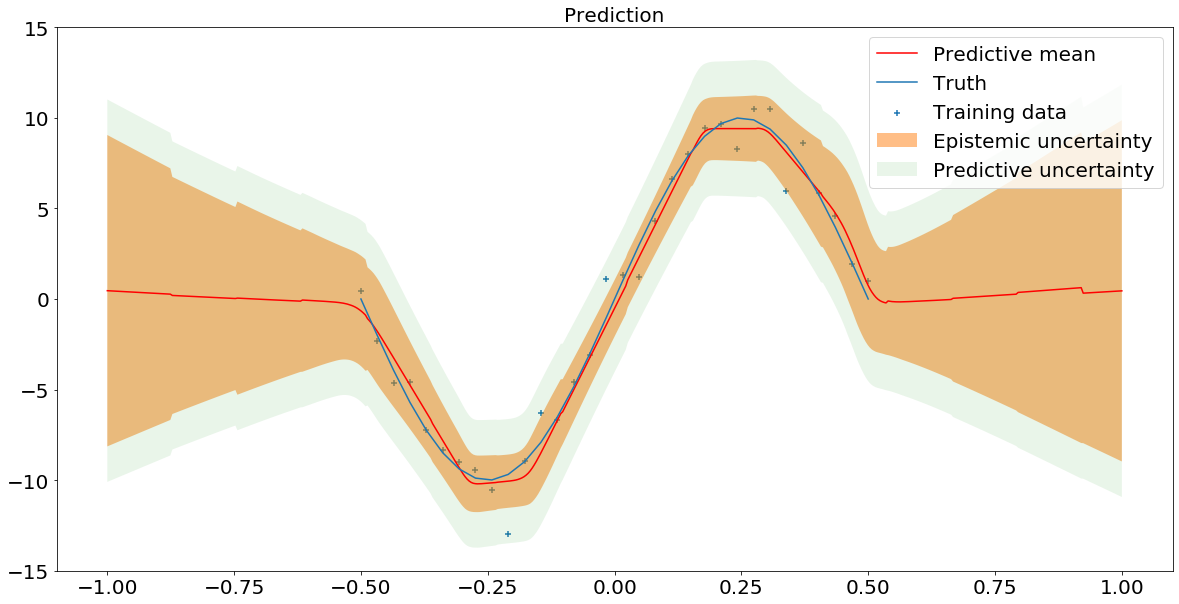

In [30]:

plt.plot(X_test, y_mean, 'r-', label='Predictive mean');
plt.scatter(X, y, marker='+', label='Training data')
plt.fill_between(X_test.ravel(), 
                 y_mean + 2 * y_sigma, 
                 y_mean - 2 * y_sigma, 
                 alpha=0.5, label='Epistemic uncertainty')
plt.fill_between(
    X_test.ravel(), 
                 y_mean + 2 * y_sigma + 1.96, 
                 y_mean - 2 * y_sigma - 1.96, 
                 alpha=0.1, label='Predictive uncertainty'
)
plt.ylim([-15,15])
plt.plot(X, y_true, label='Truth')
plt.title('Prediction')
plt.legend();

In [8]:
n_b_samples = 20

y_pred_bootstrap_list = []

for j in range(n_b_samples):
    exp_weights = np.random.exponential(size = len(y))
    model.reset_states()
    model.compile(loss=neg_log_likelihood, optimizer=optimizers.Adam(lr=0.03), metrics=['mse'])
    model.fit(X, y, batch_size=batch_size,sample_weight = exp_weights, epochs=1500, verbose=0);
    y_pred_list = []
    for i in tqdm.tqdm(range(50)):
        y_pred = model.predict(X_test)
        y_pred_list.append(y_pred)
    y_preds = np.concatenate(y_pred_list, axis=1)
    y_mean = np.mean(y_preds, axis=1)
    y_pred_bootstrap_list.append(y_mean)    


100%|██████████| 50/50 [00:01<00:00, 25.52it/s]


In [9]:

grand_mean = np.mean(y_pred_bootstrap_list, axis = 0)
grand_sigma = np.std(y_pred_bootstrap_list, axis = 0)

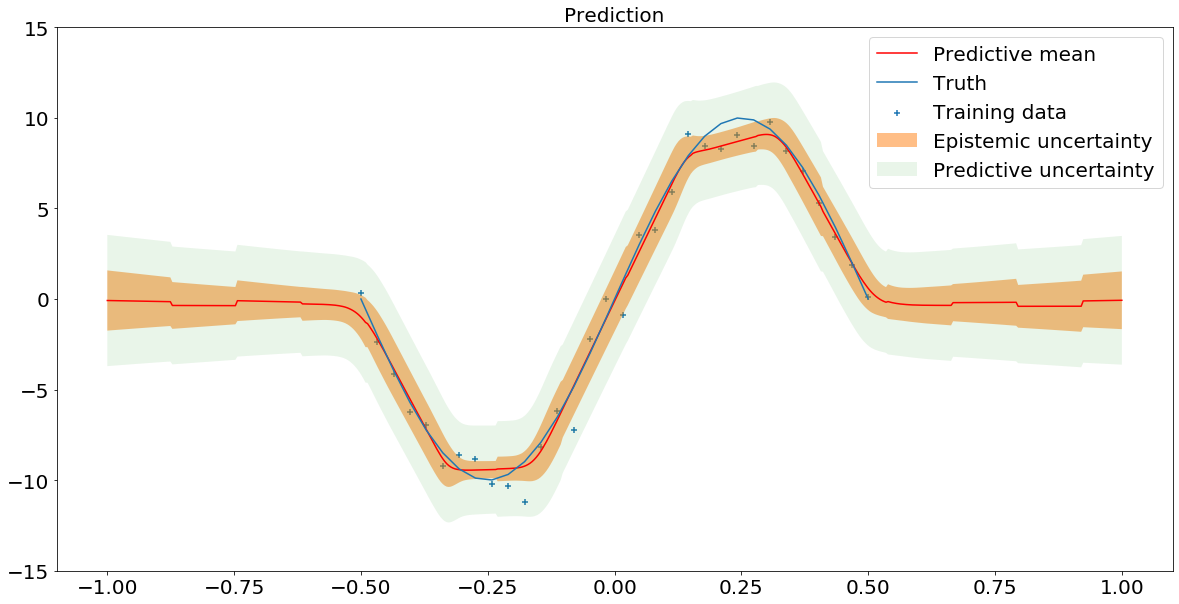

In [10]:
plt.plot(X_test, grand_mean, 'r-', label='Predictive mean');
plt.scatter(X, y, marker='+', label='Training data')
plt.fill_between(X_test.ravel(), 
                 grand_mean + 2 * grand_sigma, 
                 grand_mean - 2 * grand_sigma, 
                 alpha=0.5, label='Epistemic uncertainty')
plt.fill_between(X_test.ravel(), 
                 grand_mean + 2 * grand_sigma + 1.96, 
                 grand_mean - 2 * grand_sigma - 1.96, 
                 alpha=0.1, label='Predictive uncertainty')
plt.title('Prediction')
plt.ylim([-15,15])
plt.plot(X, y_true, label='Truth')
plt.legend();

In [107]:
exp_weights/2

array([0.45626085, 0.73274346, 0.60275796, 0.61071913, 1.04900013,
       0.15048722, 1.80295593, 0.31483099, 0.21975091, 1.66993025,
       0.64708564, 0.09040182, 1.54802833, 1.06905843, 1.87805018,
       1.630381  , 0.49756394, 0.08932446, 0.32244335, 0.62604242,
       0.2592475 , 2.0227412 , 0.01839843, 0.23152075, 0.01504489,
       0.19576361, 0.73433838, 0.52926743, 0.01964532, 0.30502012,
       0.66885056, 0.18645254, 0.2182656 , 0.13496268, 0.05716285,
       0.11646645, 0.07799852, 0.01189723, 1.2541057 , 0.1064098 ,
       0.01226811, 0.14251987, 0.60444433, 0.04036752, 0.05173114,
       0.10874466, 0.6450445 , 0.68843785, 0.70161215, 0.96793863,
       0.96559651, 0.10946332, 0.30190257, 0.1607827 , 1.02933723,
       0.8218913 , 0.70331766, 0.43795381, 0.23656723, 0.50088919,
       0.37295125, 0.42733227, 0.54925991, 1.10600209])

In [108]:
len(grand_mean)

500

In [109]:
X_pred = X_test[200:300]

In [110]:
y_new = f(X_pred, sigma=noise)

In [111]:
y_new = np.concatenate(y_new, axis =0)

In [112]:
np.mean(np.logical_and( np.less(y_new, y_mean[200:300] + 2 * y_sigma[200:300] + 1.96),
np.less(y_mean[200:300] - 2 * y_sigma[200:300] - 1.96, y_new)))

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: RuntimeWarning: invalid value encountered in less
  """Entry point for launching an IPython kernel.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in less
  


0.0

In [113]:
np.mean( np.logical_and( np.less(y_new, grand_mean[200:300] + 2 * grand_sigma[200:300] + 1.96),
np.less(grand_mean[200:300] - 2 * grand_sigma[200:300] - 1.96, y_new)))

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: RuntimeWarning: invalid value encountered in less
  """Entry point for launching an IPython kernel.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in less
  


0.0

In [114]:
var_cov = 0
vwlb_cov = 0

for i in range(100):
    y_new = f(X_pred, sigma=noise)
    y_new = np.concatenate(y_new, axis =0)
    var_cov = var_cov + np.mean(np.logical_and( np.less(y_new, y_mean[200:300] + 2 * y_sigma[200:300] + 1.96),
np.less(y_mean[200:300] - 2 * y_sigma[200:300] - 1.96, y_new)))
    vwlb_cov = vwlb_cov + np.mean( np.logical_and( np.less(y_new, grand_mean[200:300] + 2 * grand_sigma[200:300] + 1.96),
np.less(grand_mean[200:300] - 2 * grand_sigma[200:300] - 1.96, y_new)))

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: RuntimeWarning: invalid value encountered in less
  import sys
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in less
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: RuntimeWarning: invalid value encountered in less
  if __name__ == '__main__':
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:10: RuntimeWarning: invalid value encountered in less
  # Remove the CWD from sys.path while we load stuff.


In [116]:
var_cov

0.0